In [1]:
import sqlite3 as sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

В этом проекте(задание https://www.dataquest.io/m/191/guided-project%3A-answering-business-questions-using-sql/) я планирую исследовать базу данных chinook.db и планирую ответить на вопросы бизнеса использую SQL-запросы. 

Во-первых, создададим две функции
1. Запуска SQL-запроса
2. Запуск служебной комманды

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

Посмотрим, что у нас есть в базе данных

In [4]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Определяем лучший музыкальный стиль


Следуя заданию, определяем музыка какого стиля лучше всего продается в США и альбомы какого стиля следует добавить в магазин. Лист исполнителей и музыкальных стилей 
1) Regal, hip-hop
2) Red Tone, punk
3) Slim Jim Bites, blues
4) Meteor and the Girls, pop

In [5]:
albums_to_purchase = '''
select g.name genre,
		count(il.invoice_line_id) tracks_sold,
		cast(count(il.invoice_line_id) as float) / (
											select COUNT(*) 
												from invoice_line il1 
													inner join invoice inv1 on inv1.invoice_id = il1.invoice_id
													inner join customer cust1 on cust1.customer_id = inv1.customer_id
											where cust1.country = 'USA'
													) percentage_sold
		from invoice_line il 
					inner join track t on t.track_id = il.track_id
					inner join genre g on g.genre_id = t.genre_id
					inner join invoice inv on inv.invoice_id = il.invoice_id
					inner join customer cust on cust.customer_id = inv.customer_id
		where cust.country = 'USA'
		group by 1
		order by 2 desc
		limit 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


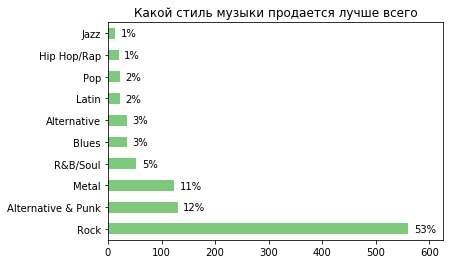

In [6]:
album_to_purch = run_query(albums_to_purchase)
album_to_purch.set_index("genre", inplace=True, drop=True)

album_to_purch["tracks_sold"].plot.barh(
    title="Какой стиль музыки продается лучше всего",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

for i, label in enumerate(list(album_to_purch.index)):
    score = album_to_purch.loc[label, "tracks_sold"]
    label = (album_to_purch.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.ylabel('')
plt.show()

In [7]:
album_to_purch.loc[(album_to_purch.index == 'Hip Hop/Rap') |
                   (album_to_purch.index == 'Alternative & Punk') |
                   (album_to_purch.index == 'Pop') |
                   (album_to_purch.index == 'Blues')
                  ]['percentage_sold']*100

genre
Alternative & Punk    12.369172
Blues                  3.425309
Pop                    2.093245
Hip Hop/Rap            1.902950
Name: percentage_sold, dtype: float64

# Выводы


Анализирую выборку можно сказать, чтео старый добрый рок вне конкуренции. 
Однако, если выбирать между предложенных испольнителей - то в магазин нужно добавить панк-рок культуры. 
12.36% - это круто.

так что ответ - Red Tone

# Анализируем продажи по людям

In [8]:
q2 = '''
select e.employee_id, 
		e.first_name||' '||e.last_name as emploee_name,
		e.hire_date,
		sum(ince.total) as total_sales
	from employee e inner join customer cust on cust.support_rep_id = e.employee_id
					inner join invoice ince on ince.customer_id = e.employee_id
	group by e.employee_id
	order by 4 desc
'''


sales_by_enploee = run_query(q2)

sales_by_enploee

,employee_id,emploee_name,hire_date,total_sales
0,5,Steve Johnson,2017-10-17 00:00:00,2601.72
1,3,Jane Peacock,2017-04-01 00:00:00,2099.79
2,4,Margaret Park,2017-05-03 00:00:00,1445.40


# Топ3 крутых продажников на графике

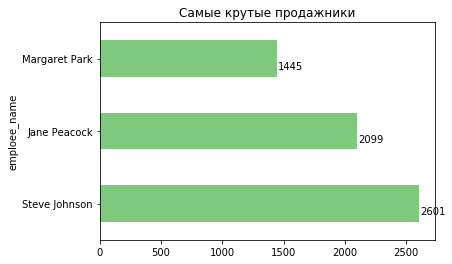

In [9]:
sales_by_enploee.plot.barh(
    x="emploee_name", y="total_sales",
    title="Самые крутые продажники",
    legend = False,
    colormap=plt.cm.Accent
)

for i, label in enumerate(list(sales_by_enploee.index)):
    score = sales_by_enploee.loc[label, "total_sales"]
    label = (sales_by_enploee.loc[label, "total_sales"]
            ).astype(int).astype(str)
    plt.annotate(str(label), (score + 10, i - 0.15))


plt.show()

# Выводы 

Вообще странно - в самых крутых продажниках "Зеленый" Стив. А "старушка" Джейн на втором месте. "старушка" и "зеленый" - это по дате найма. 

Как <B>идея</B>, к которой можно вернутся - посмотреть, на каких рынках и на каких стилях работают Стив и Джейн. 
Может у Стива кинул альбом - он и заколосился. 

# Отчет продажи по странам

In [10]:
q3 = '''
select country_other,
		count(distinct customer_id) customers,
		sum(unit_price) total_sales,
		sum(unit_price) / count(distinct customer_id) customer_value,
		sum(unit_price) / count(distinct invoice_id) average_order,			 
			 case when country_other = "Other" then 1
						else 0
			 end as sort 
			 
		from (
					select c.customer_id,
								 c.country,
								 case 
										when (select count(*) from customer where country = c.country) = 1 then "Other"
										else c.country
								 end as country_other,
							 il.* 
						from invoice_line il 
						 inner join invoice inv on inv.invoice_id = il.invoice_id
						 inner join customer c on c.customer_id = inv.customer_id
			)
		 group by country_other
		 order by sort, country_other
'''


sales_by_country = run_query(q3)
sales_by_country.set_index("country_other", drop=True, inplace=True)
sales_by_country["perc"] = sales_by_country['total_sales'] / sales_by_country['total_sales'].sum() *100
sales_by_country

,customers,total_sales,customer_value,average_order,sort,perc
country_other,,,,,,
Brazil,5,427.68,85.536000,7.011148,0,9.081354
Canada,8,535.59,66.948750,7.047237,0,11.372714
Czech Republic,2,273.24,136.620000,9.108000,0,5.801976
France,5,389.07,77.814000,7.781400,0,8.261509
Germany,4,334.62,83.655000,8.161463,0,7.105318
India,2,183.15,91.575000,8.721429,0,3.889006
Portugal,2,185.13,92.565000,6.383793,0,3.931049
USA,13,1040.49,80.037692,7.942672,0,22.093757
United Kingdom,3,245.52,81.840000,8.768571,0,5.213370


# Визуализация данных

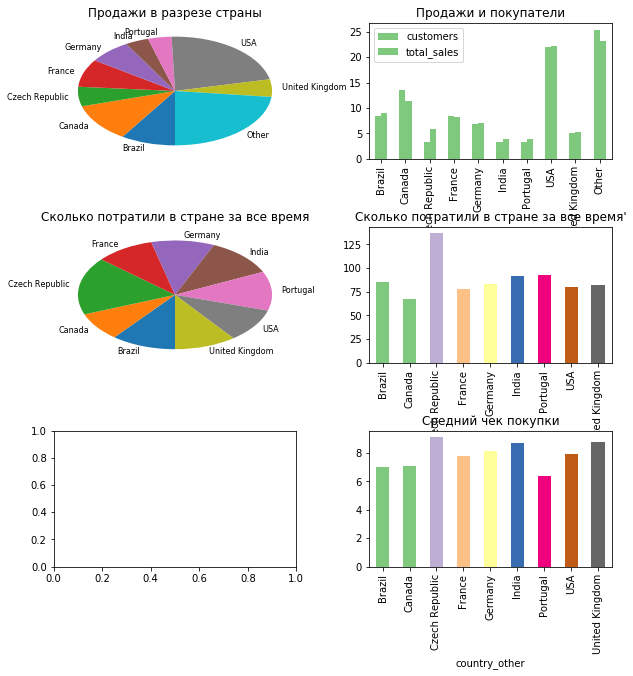

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#Пытаемся использовать один цвет для одной страны(ну, типа по заданию)
colors = plt.cycler('color', plt.cm.Accent(np.linspace(0, 1, sales_by_country.shape[0])))


ax1.set_prop_cycle(colors)
ax3.set_prop_cycle(colors)


#1. Что первым приходит в голову - продажи в разбивке по стране
total_salse_by_country = sales_by_country["total_sales"].copy().rename('')
total_salse_by_country

total_salse_by_country.plot.pie(
    ax = ax1,
    startangle = -90,
    counterclock = False,
    title = 'Продажи в разрезе страны',
    fontsize = 8,
    wedgeprops = {'linewidth':0}
    )

#3. Что вторым приходит в голову - продажи в разбивке по стране но относительно сколько потратил один человек
total_salse_by_customer = sales_by_country["customer_value"].copy().rename('')
total_salse_by_customer.drop("Other", inplace = True)

total_salse_by_customer.plot.pie(
    ax = ax3,
    startangle = -90,
    counterclock = False,
    title = 'Сколько потратили в стране за все время',
    fontsize = 8,
    wedgeprops = {'linewidth':0}
    )


total_salse_by_customer.plot.bar(
      ax = ax4, 
      color = plt.cm.Accent(np.linspace(0, 1, sales_by_country.shape[0])),
      title="Сколько потратили в стране за все время'"
)



#2. Сколько тратят люди в стране на музыку и сколько вообще таких транжир
customers_and_sales = sales_by_country[["customers","total_sales"]].copy()

customers_and_sales["customers"] /= customers_and_sales["customers"].sum() / 100
customers_and_sales["total_sales"] /= customers_and_sales["total_sales"].sum() / 100

customers_and_sales.plot.bar(
      ax = ax2, 
      color = plt.cm.Accent(np.linspace(0, 1, sales_by_country.shape[0])),
      title="Продажи и покупатели"
)

#3. Средний чек покупки
average_order = sales_by_country["average_order"].copy()
average_order.drop("Other", inplace = True)

average_order.plot.bar(
      ax = ax6, 
      color = plt.cm.Accent(np.linspace(0, 1, sales_by_country.shape[0])),
      title="Средний чек покупки"
)
ax4.set_prop_cycle(colors)



# Выводы

Опираясь на графики я бы сказал, что самый недооценный рынок - это Чешская республика(сейчас 5% от рынка). При небольшом кол-ве транжир, средний чек у них хороший. 
Еще можно посмотреть в сторону Индии и Англии.


Ну и не следует забывать, что БД содержит не много данных. Возможно полная БД даст другие выводы

# Оценить что чаще покупают, целиком альбомы или отдельные треки


Какой-то очень гимморойный запрос получился

In [12]:
q4 = '''
select     
		   count(il2.invoice_id) count_of_invoices,
       cast(count(il2.invoice_id) as float) / ( select count(*) from  invoice) percent,
       case 
						when 
						(
								select t.track_id from track t 
								 where t.album_id = (select t2.album_id from  track t2 where t2.track_id = il2.first_track_id
																		) 
								except  
								select il3.track_id from invoice_line il3 where il2.invoice_id = il3.invoice_id
            ) is null 
						and (
                  select il3.track_id from invoice_line il3 where il3.invoice_id = il2.invoice_id
                  except  
                  select t.track_id from track t
                  where t.album_id = (select t2.album_id from track t2 where t2.track_id = il2.first_track_id
                                     ) 						
			      )	is null		
						then "Yes"
					  else "No"	
			 end as "album_purch"
			 
  from( 
				select il.invoice_id,
							 min(il.track_id) first_track_id
				from invoice_line il 
					 group by 1
       ) il2
	 group by album_purch
'''

albums_and_tracks = run_query(q4)

albums_and_tracks

,count_of_invoices,percent,album_purch
0,500,0.814332,No
1,114,0.185668,Yes


# Выводы

Альбомы покупают реже треков. Всего-то 18% покупок. 
Хотя... я сам так делаю. 

Так что упираться продажей целых альбомов - не очень выгодно.

